In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Загрузка массив данных и меток класса
column_names = [str(i) for i in range(1, 17)] + ['class']
data = pd.read_csv('/content/drive/MyDrive/MAKMD/var_0.csv', sep = ' ', names=column_names)
labels = data.iloc[:, -1]

In [ ]:
data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,class
0,116.0,4.0,195.0,1197.0,93.0,35.0,947.0,244.0,79.0,20.0,214.0,3.0,120.0,10.0,431.0,77.0,1.0
1,93.0,26.0,217.0,1841.0,111.0,24.0,1318.0,316.0,71.0,17.0,157.0,17.0,119.0,13.0,463.0,78.0,0.0
2,70.0,8.0,191.0,627.0,118.0,31.0,514.0,157.0,81.0,25.0,171.0,-34.0,78.0,10.0,451.0,83.0,1.0
3,96.0,88.0,387.0,572.0,57.0,16.0,545.0,104.0,95.0,18.0,94.0,17.0,184.0,19.0,320.0,61.0,0.0
4,31.0,35.0,227.0,332.0,36.0,33.0,398.0,84.0,119.0,25.0,101.0,-15.0,66.0,7.0,381.0,69.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50.0,22.0,177.0,1712.0,101.0,30.0,1632.0,499.0,95.0,29.0,165.0,1.0,72.0,6.0,498.0,79.0,0.0
1996,105.0,74.0,341.0,694.0,97.0,30.0,622.0,156.0,89.0,22.0,96.0,12.0,179.0,19.0,299.0,58.0,0.0
1997,132.0,0.0,399.0,1547.0,214.0,21.0,1319.0,282.0,85.0,18.0,215.0,17.0,132.0,12.0,498.0,82.0,0.0
1998,77.0,0.0,200.0,1032.0,96.0,38.0,971.0,280.0,94.0,27.0,200.0,-11.0,77.0,8.0,416.0,81.0,1.0


In [ ]:
# 2. Разделение данных на обучающую и тестовую выборки (80% и 20%), где внутри каждой выборки равное количество классов
class_0 = data[labels == 0.0]
class_1 = data[labels == 1.0]

train_class_0 = class_0.sample(frac=0.8, random_state=42)
test_class_0 = class_0.drop(train_class_0.index)
train_class_1 = class_1.sample(frac=0.8, random_state=42)
test_class_1 = class_1.drop(train_class_1.index)

train_data = pd.concat([train_class_0, train_class_1]).sample(frac=1, random_state=42)
train_labels = labels.loc[train_data.index]
test_data = pd.concat([test_class_0, test_class_1]).sample(frac=1, random_state=42)
test_labels = labels.loc[test_data.index]

In [ ]:
# 3. Нормализация данных (обеспечение нулевого среднего и дисперсии 1)
def normalize(data, mean, std):
    return (data - mean) / std

# Отделяем признаки и классы
train_features = train_data.drop(columns=['class'])  # Признаки
train_labels = train_data['class']  # Класс
test_features = test_data.drop(columns=['class'])
test_labels = test_data['class']

# Нормализуем только признаки (без классов)
mean = train_features.mean()
std = train_features.std()
train_features_normalized = normalize(train_features, mean, std)
test_features_normalized = normalize(test_features, mean, std)

# Соединяем признаки с классами
train_data_normalized = train_features_normalized.copy()
train_data_normalized['class'] = train_labels
test_data_normalized = test_features_normalized.copy()
test_data_normalized['class'] = test_labels

# 3*. Удаление выбросов (3х сигмовое правило)
def remove_outliers(data, labels):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    mask = np.all((data > mean - 3 * std_dev) & (data < mean + 3 * std_dev), axis=1)
    return data[mask], labels[mask]

train_data_no_outliers, train_labels_no_outliers = remove_outliers(train_data_normalized, train_labels)
test_data_no_outliers, test_labels_no_outliers = remove_outliers(test_data_normalized, test_labels)

In [ ]:
# 4. Формирование трех массивов данных
# a) Нормализованная исходная выборка, все признаки
full_feature_data = train_data_no_outliers
test_full_feature_data = test_data_no_outliers

# b) Нормализованная исходная выборка, признаки с корреляцией не более 0.9
correlation_matrix = pd.DataFrame(train_data_no_outliers).corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
filtered_data = pd.DataFrame(train_data_no_outliers).drop(columns=to_drop)
test_filtered_data = pd.DataFrame(test_data_no_outliers).drop(columns=to_drop)

# c) Первые 3 главные компоненты по ненормализованным данным обучающей выборки
mean_original = train_data.mean() # Нормализация данных
std_original = train_data.std()
train_data_standardized = normalize(train_data, mean_original, std_original)

cov_matrix = np.cov(train_data_standardized, rowvar=False) # Вычисление ковариационных матриц
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix) # Вычисление собственных значений и собственных векторов
idx = np.argsort(eigenvalues)[::-1] # Сортировка собственных значений
eigenvectors = eigenvectors[:, idx]
eigenvectors = eigenvectors[:, :3] # Выбор первых трех главных компонент

pca_train_data = np.dot(train_data_standardized, eigenvectors) # Проекция данных на главные компоненты
pca_test_data = np.dot(normalize(test_data, mean_original, std_original), eigenvectors)

In [ ]:
print("Удаленные признаки (из выборки b): ", to_drop)
print()
print("Размерность выборки a (нормализованная полная выборка):", full_feature_data.shape)
print()
print("Размерность выборки b (нормализованная фильтрованная обучающая выборка):", filtered_data.shape)
print("Размерность выборки b (нормализованная фильтрованная тестовая выборка):", test_filtered_data.shape)

Удаленные признаки (из выборки b):  ['7', '8']

Размерность выборки a (нормализованная полная выборка): (1404, 17)

Размерность выборки b (нормализованная фильтрованная обучающая выборка): (1404, 15)
Размерность выборки b (нормализованная фильтрованная тестовая выборка): (338, 15)


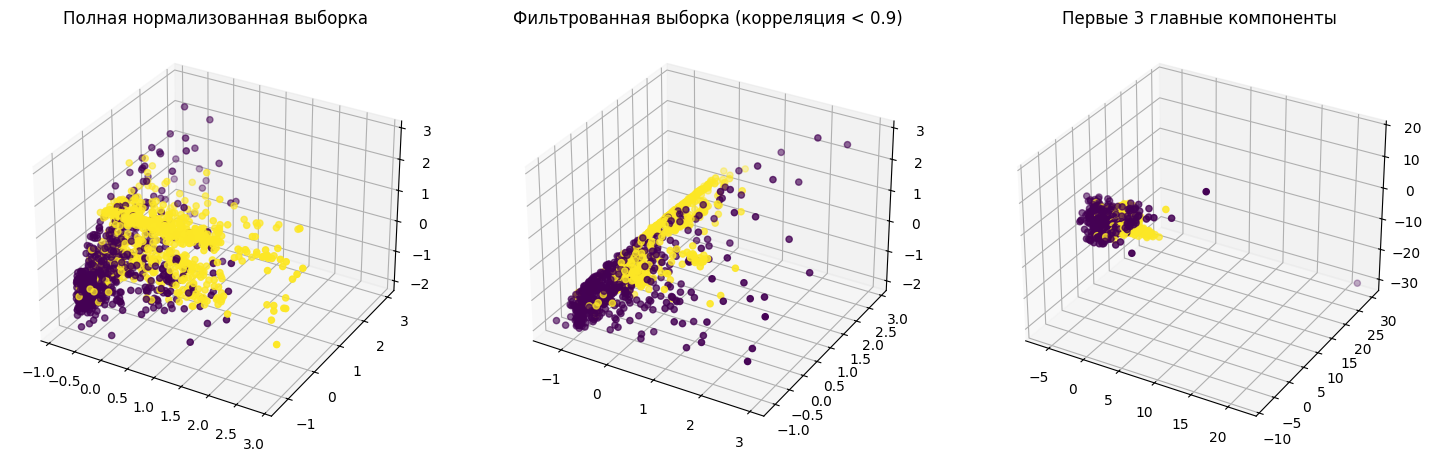

In [ ]:
# 4.1. Построение скаттерограмм (в 3х мерном пространстве для признаков, которые визуально хорошо разделимы)
fig = plt.figure(figsize=(18, 6))
# Для выборки а (полная выборка), признаки 7, 10, 15
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(full_feature_data.iloc[:, 7], full_feature_data.iloc[:, 10], full_feature_data.iloc[:, 15], c=train_labels_no_outliers, cmap='viridis')
ax1.set_title('Полная нормализованная выборка')
# Для выборки b (фильтрованная выборка), признаки 8, 12, 13
ax2 = fig.add_subplot(132, projection='3d')
filtered_data_3d = filtered_data.iloc[:, [8, 12, 13]]
ax2.scatter(filtered_data_3d.iloc[:, 0], filtered_data_3d.iloc[:, 1], filtered_data_3d.iloc[:, 2], c=train_labels_no_outliers, cmap='viridis')
ax2.set_title('Фильтрованная выборка (корреляция < 0.9)')
# Для выборки c (PCA)
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(pca_train_data[:, 0], pca_train_data[:, 1], pca_train_data[:, 2], c=train_labels, cmap='viridis')
ax3.set_title('Первые 3 главные компоненты')
plt.show()

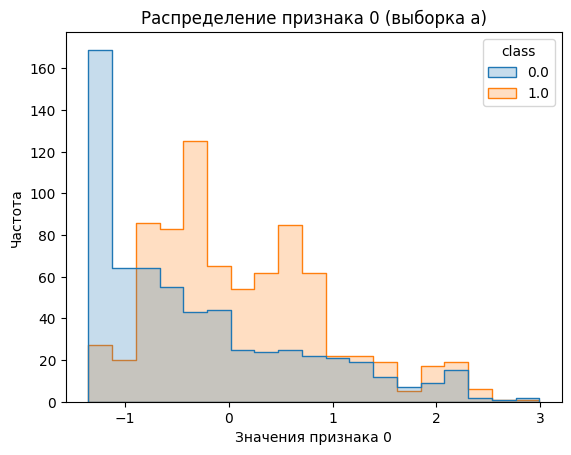

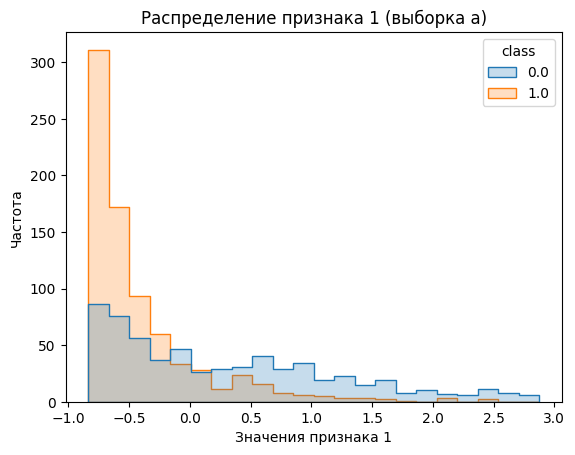

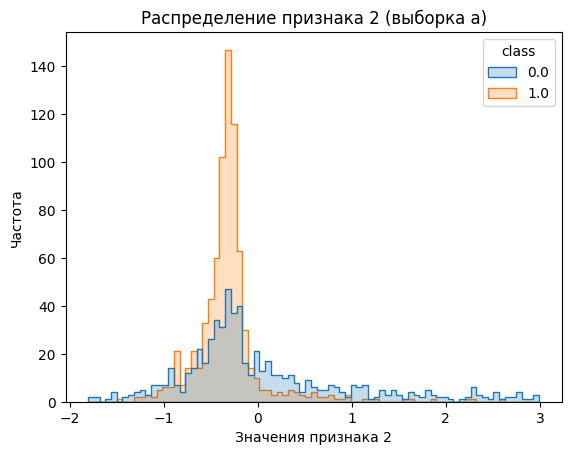

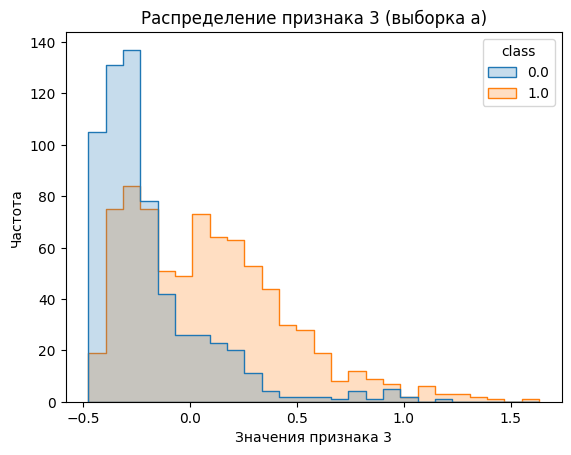

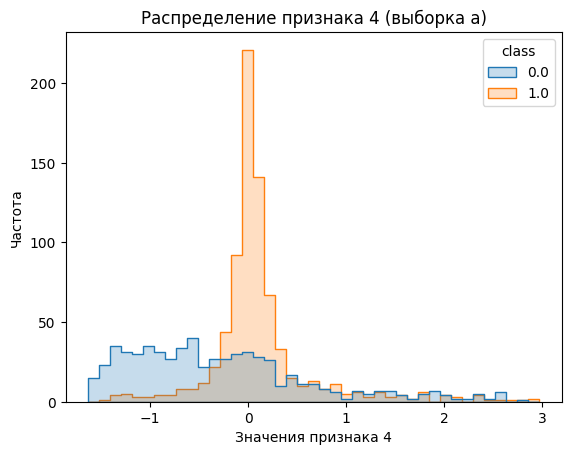

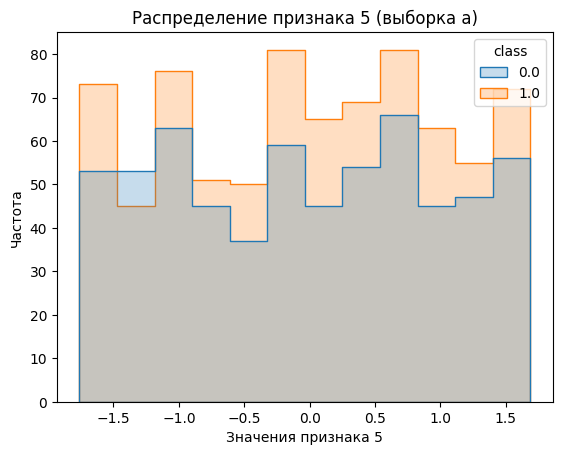

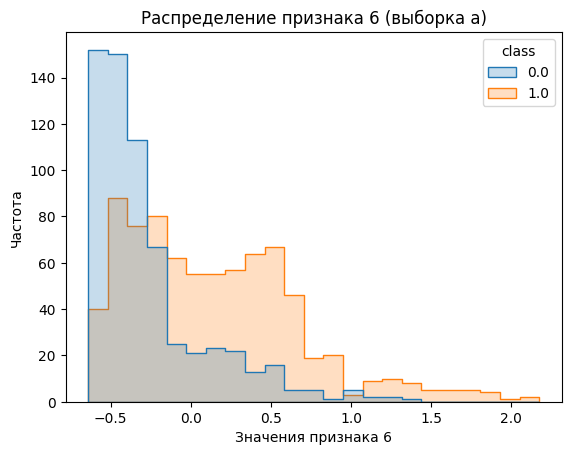

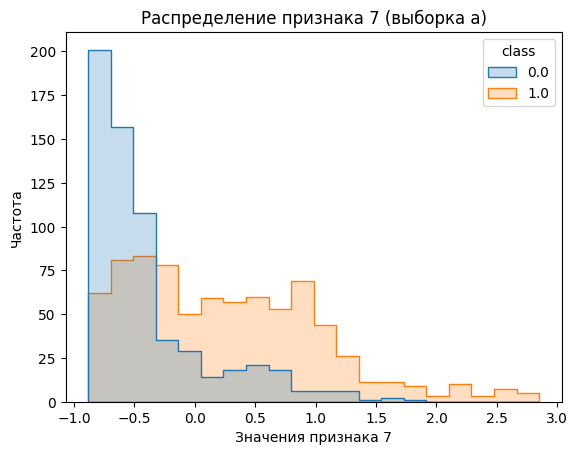

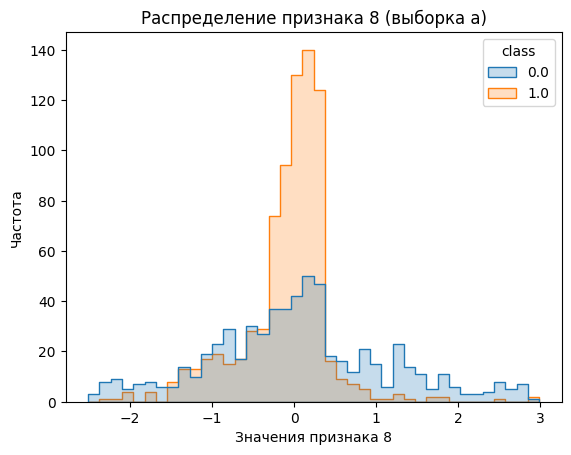

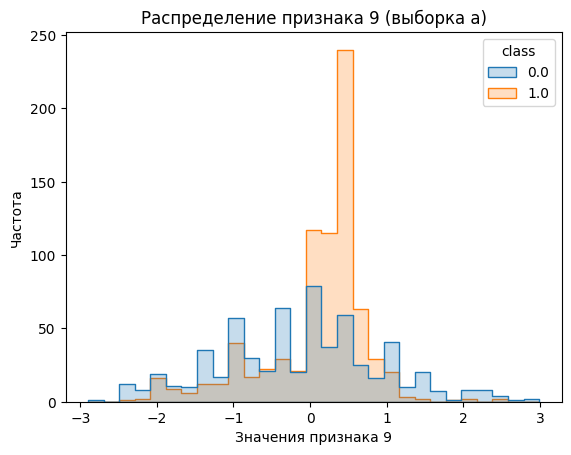

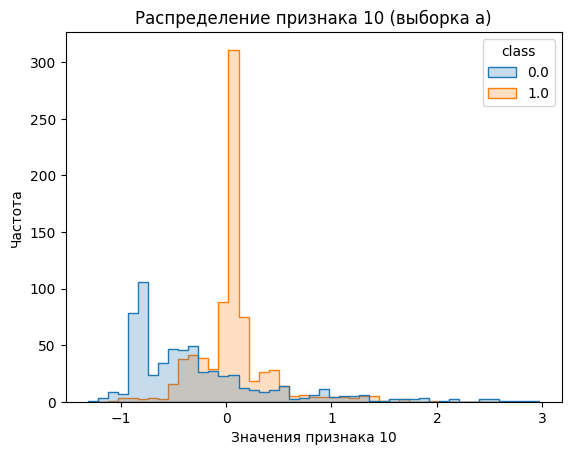

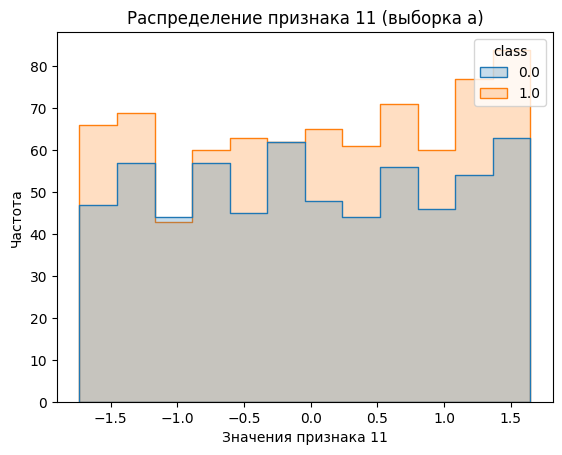

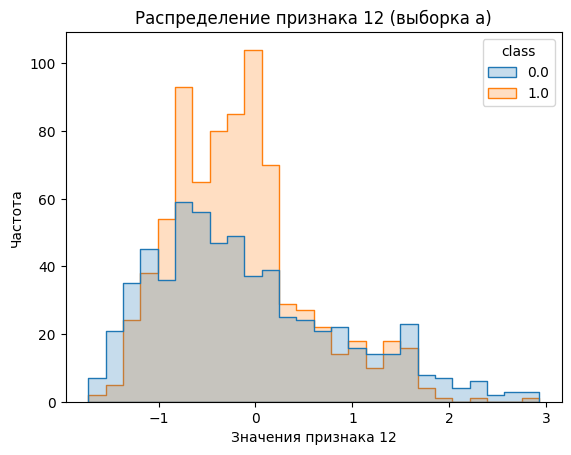

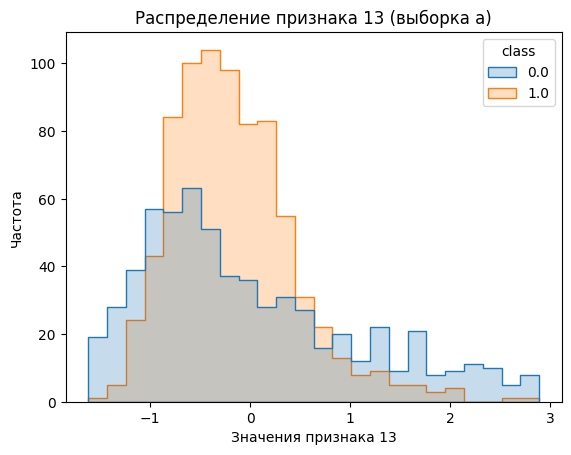

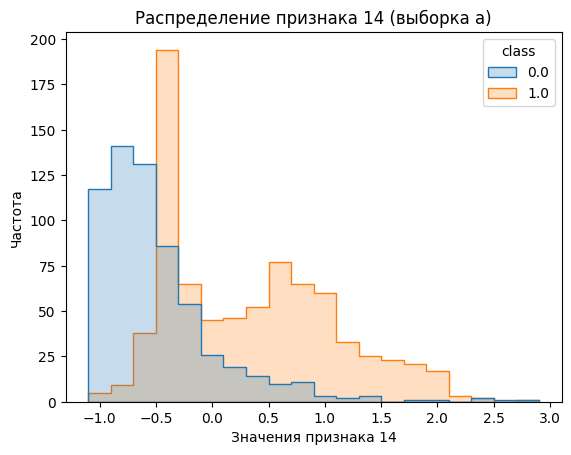

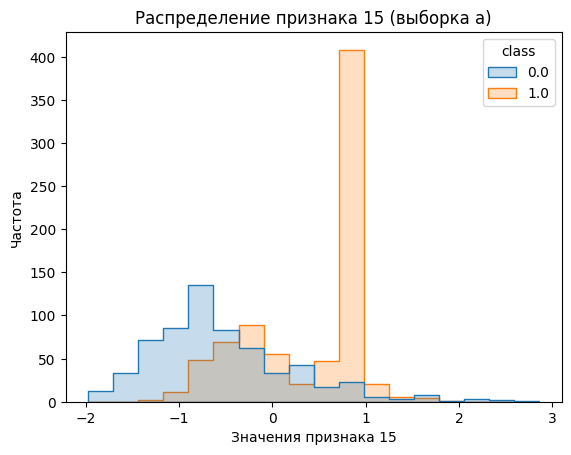

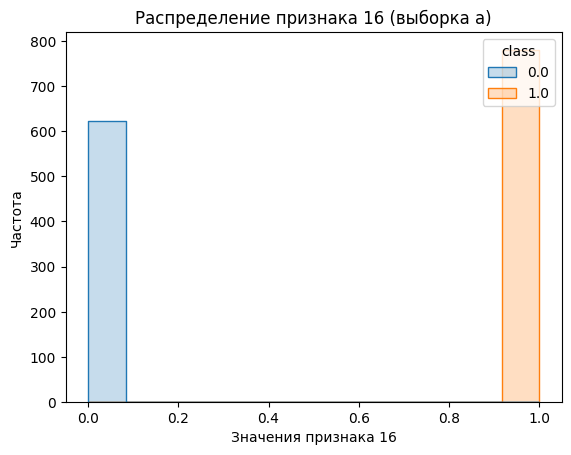

In [ ]:
# 4.2. Построение гистограмм распределения признаков (полная выборка)
for i in range(full_feature_data.shape[1]):
    sns.histplot(x=full_feature_data.iloc[:, i], kde=False, hue=train_labels_no_outliers, element='step')
    plt.title(f'Распределение признака {i} (выборка а)')
    plt.xlabel(f'Значения признака {i}')
    plt.ylabel('Частота')
    plt.show()

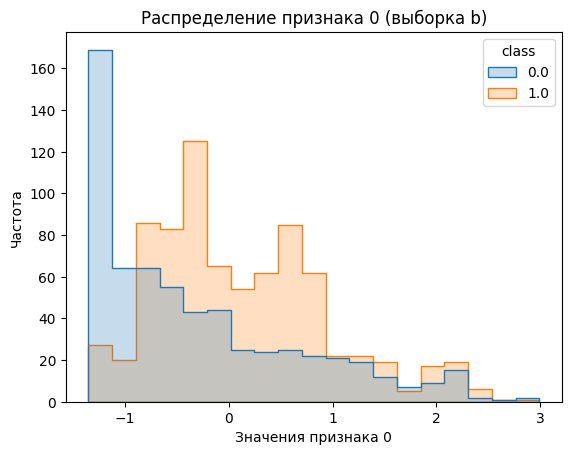

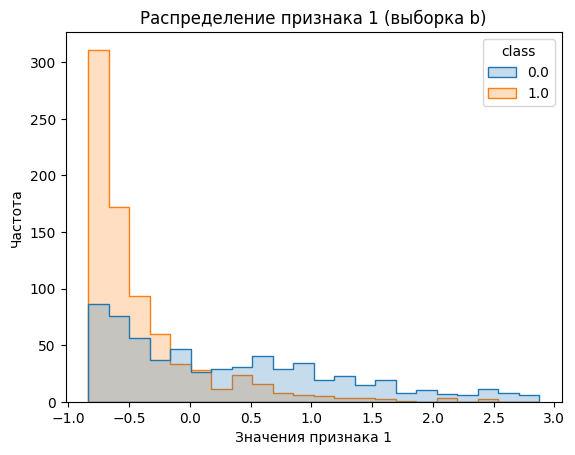

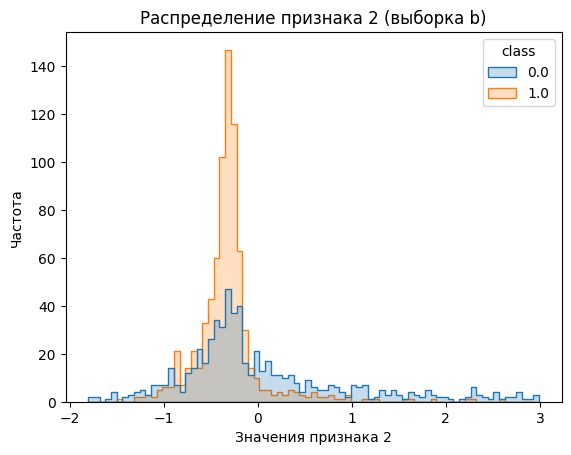

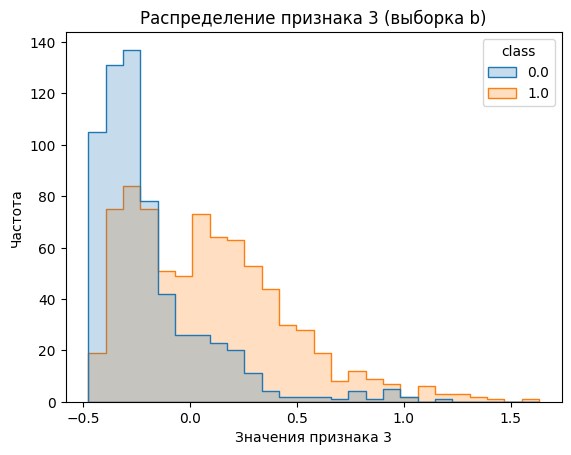

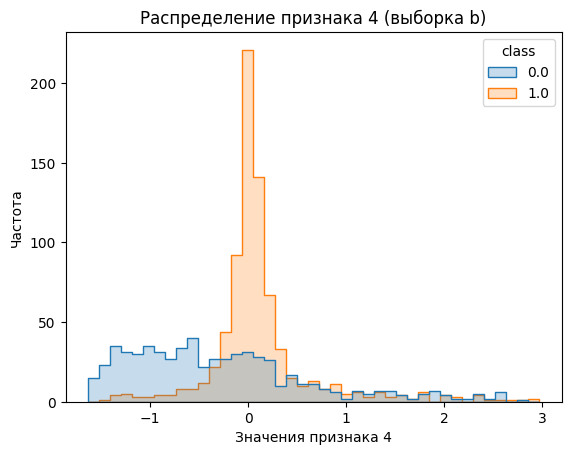

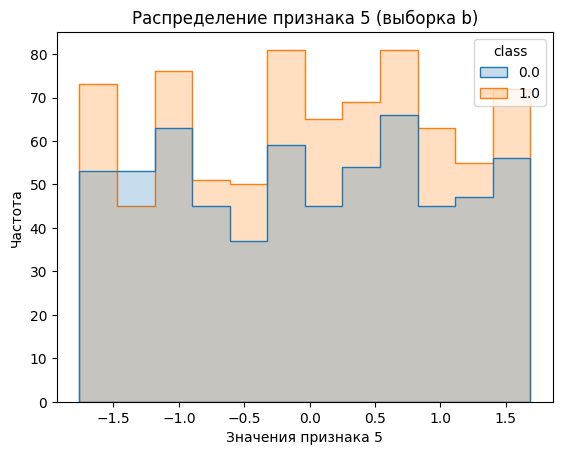

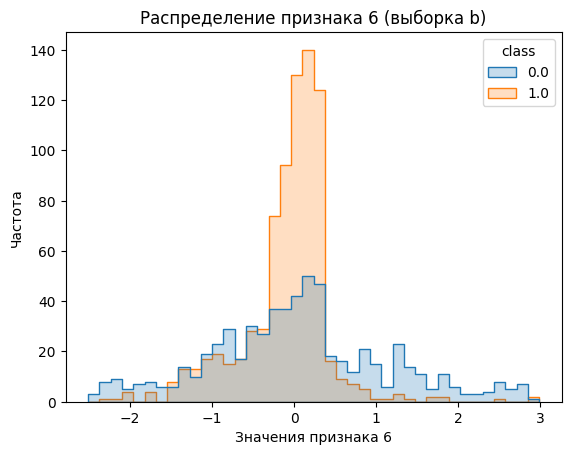

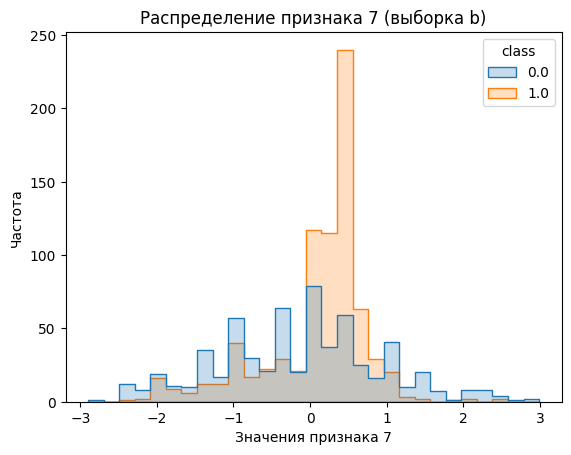

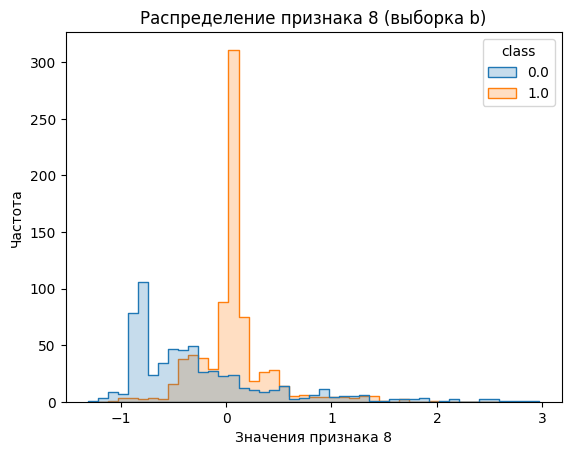

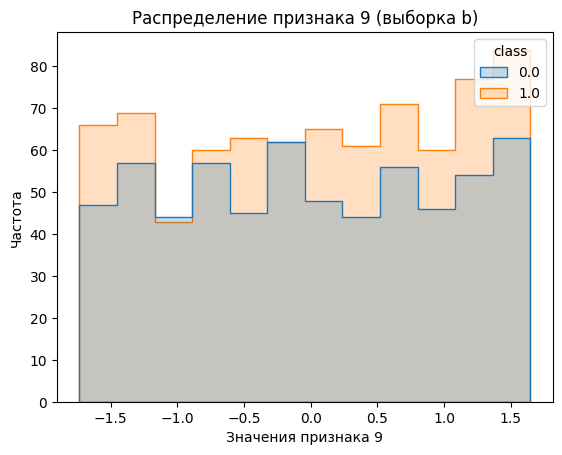

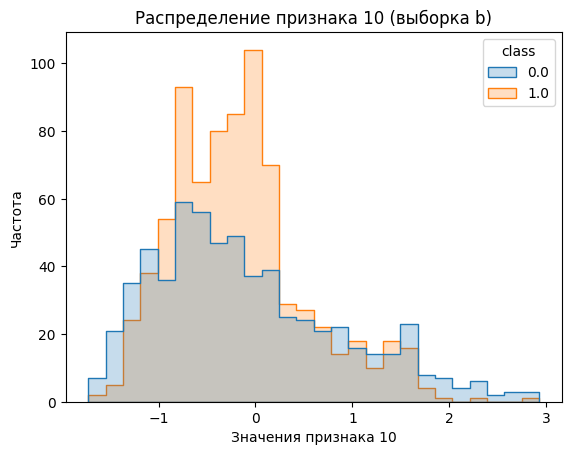

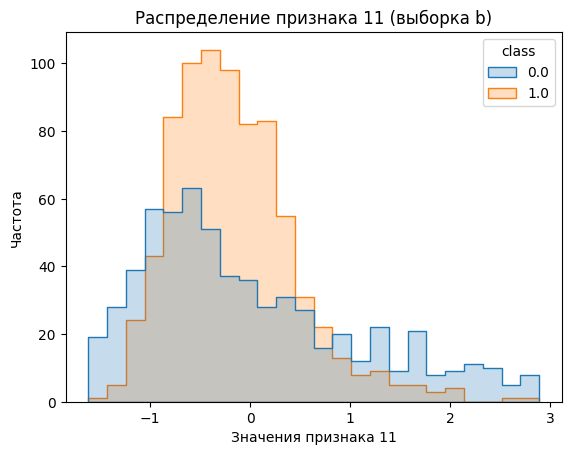

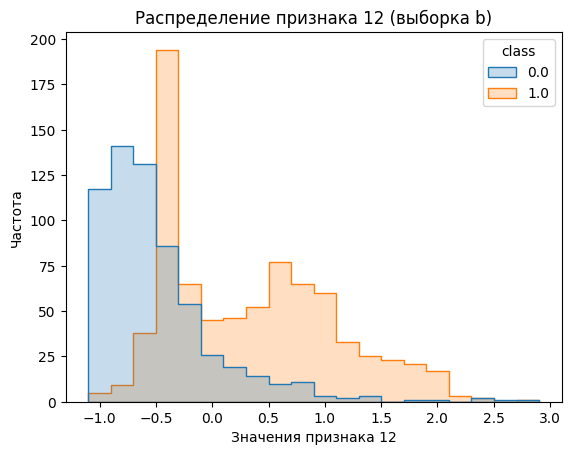

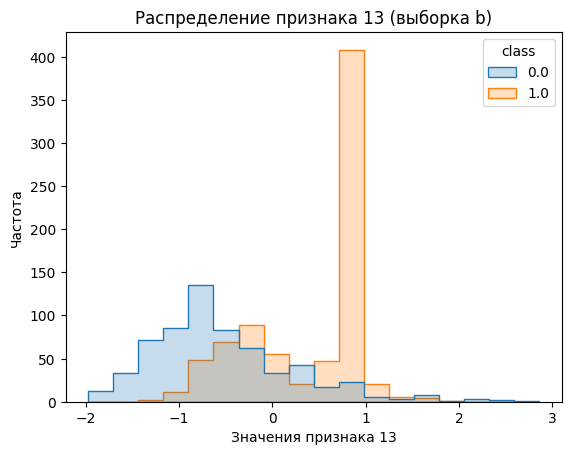

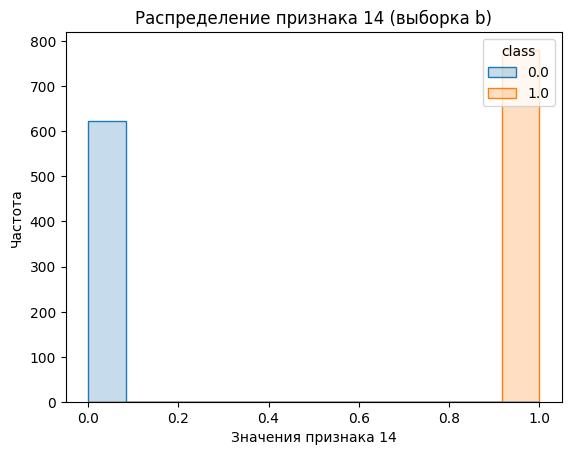

In [ ]:
# 4.2. Построение гистограмм распределения признаков (фильтрованная выборка)
for i in range(filtered_data.shape[1]):
    sns.histplot(x=filtered_data.iloc[:, i], hue=train_labels_no_outliers, element='step')
    plt.title(f'Распределение признака {i} (выборка b)')
    plt.xlabel(f'Значения признака {i}')
    plt.ylabel('Частота')
    plt.show()

In [ ]:
# 4.2. Удаление из выборки плохо разделимые признаки (фильтрованная выборка)
columns_to_remove = [5, 9, 10]
filtered_data = filtered_data.drop(filtered_data.columns[columns_to_remove], axis=1)
test_filtered_data = test_filtered_data.drop(test_filtered_data.columns[columns_to_remove], axis=1)

print("Удалены столбцы(по индексам) 5, 9, 10 из выборки b")
print()
print("Размерность выборки b (нормализованная фильтрованная обучающая выборка):", filtered_data.shape)
print("Размерность выборки b (нормализованная фильтрованная тестовая выборка):", test_filtered_data.shape)

Удалены столбцы(по индексам) 5, 9, 10 из выборки b

Размерность выборки b (нормализованная фильтрованная обучающая выборка): (1404, 12)
Размерность выборки b (нормализованная фильтрованная тестовая выборка): (338, 12)


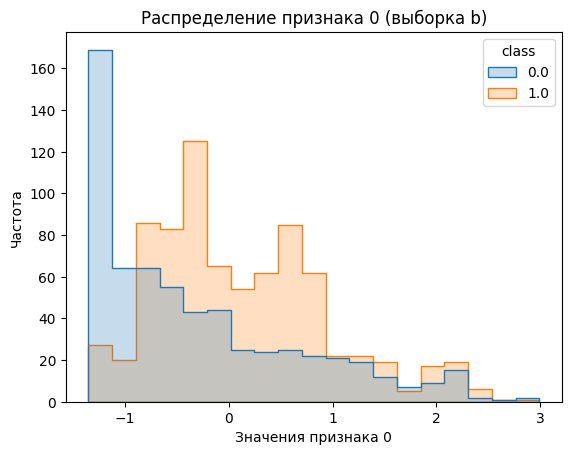

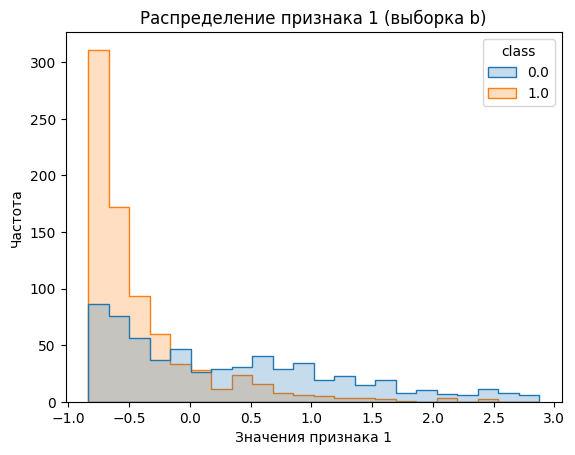

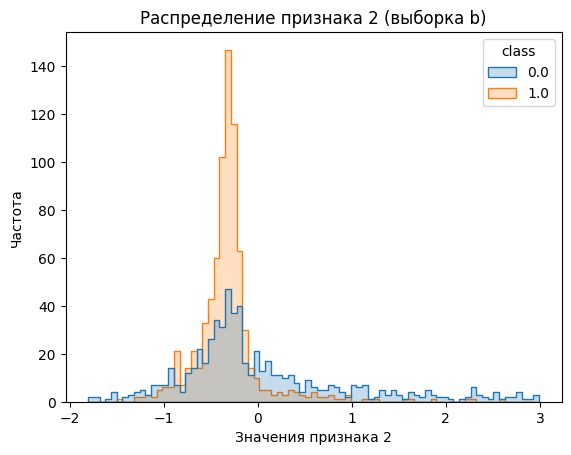

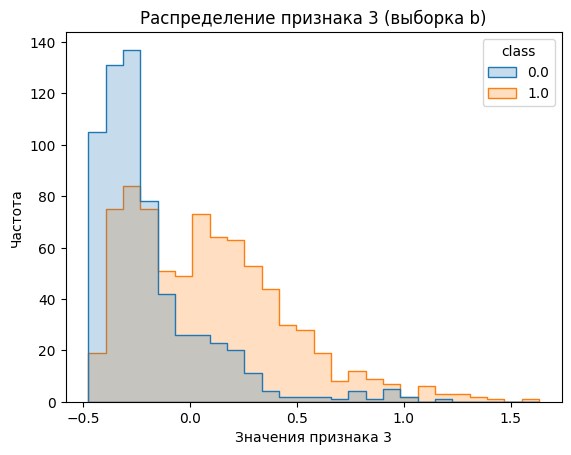

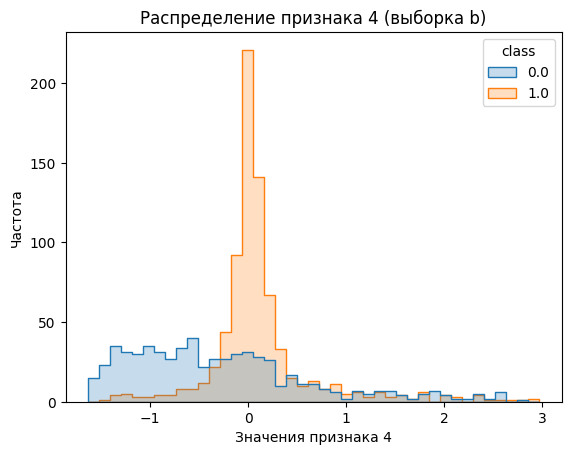

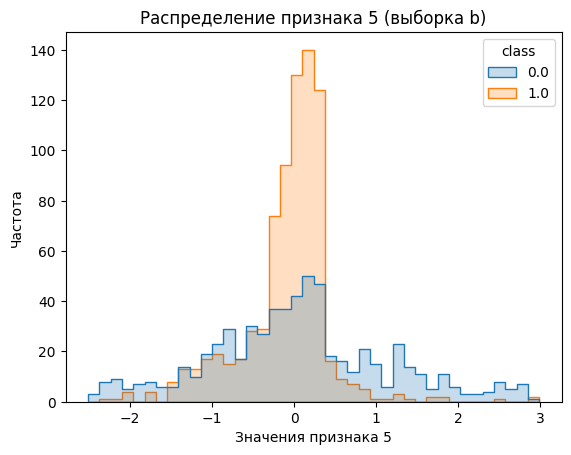

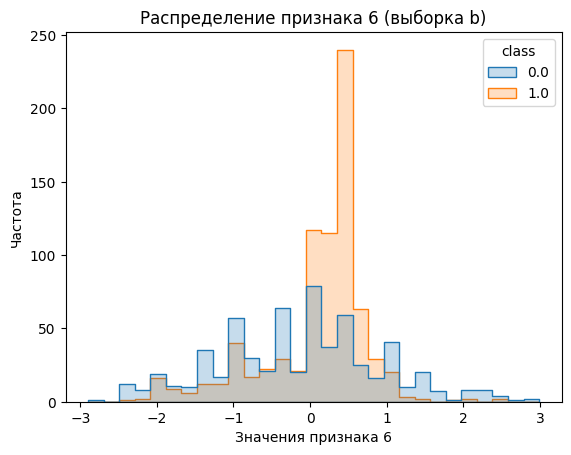

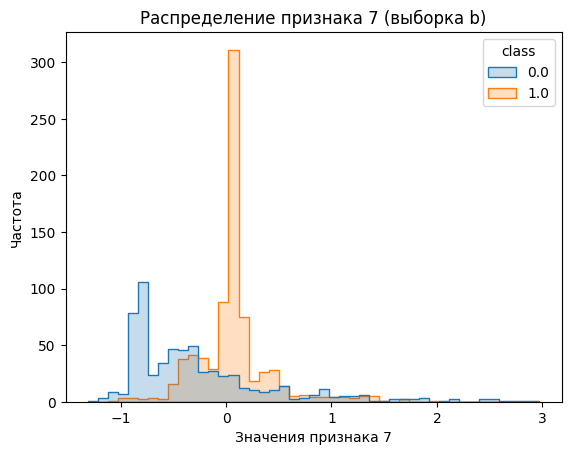

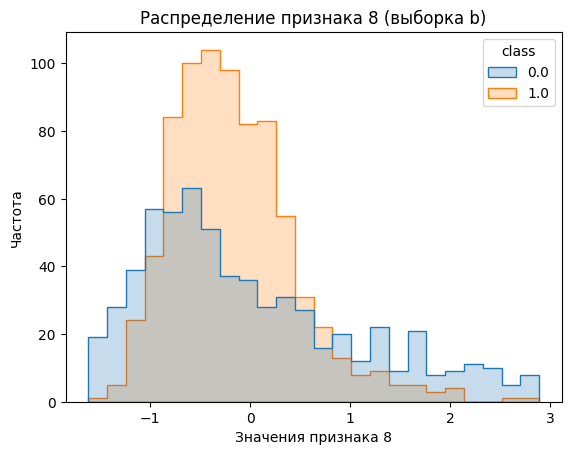

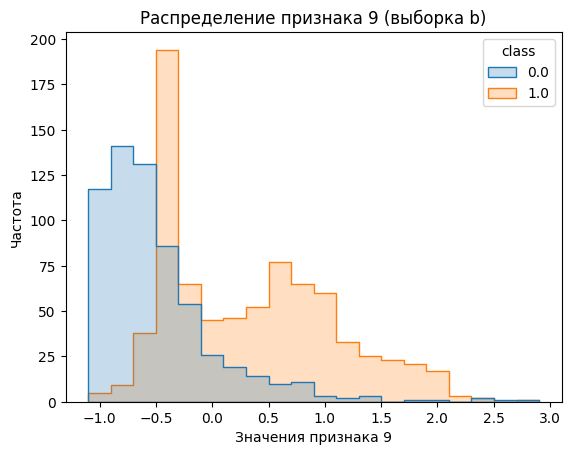

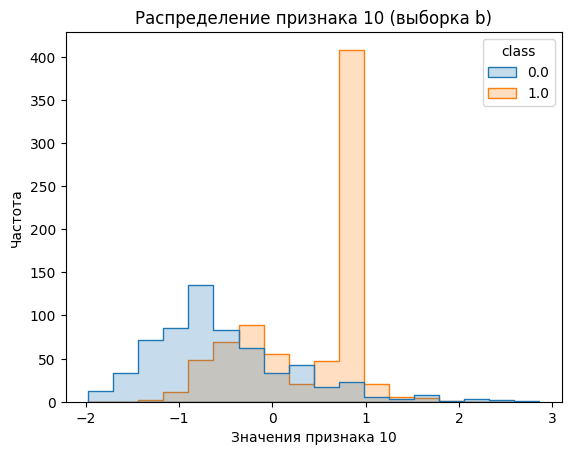

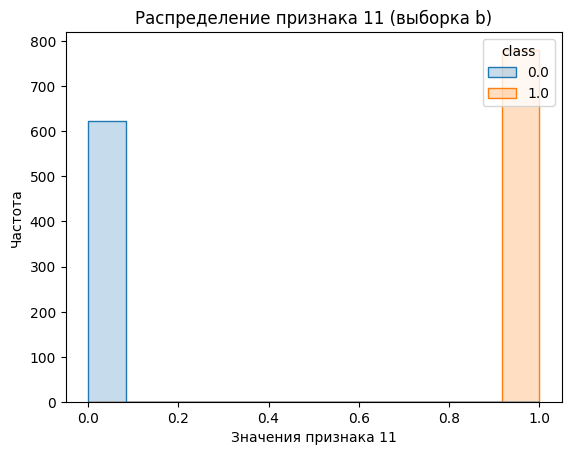

In [ ]:
# Построение гистограмм после удаления признаков
for i in range(filtered_data.shape[1]):
    sns.histplot(x=filtered_data.iloc[:, i], hue=train_labels_no_outliers, element='step')
    plt.title(f'Распределение признака {i} (выборка b)')
    plt.xlabel(f'Значения признака {i}')
    plt.ylabel('Частота')
    plt.show()

In [ ]:
# 5. а) Линейный дискриминант Фишера
def LDA(target, train_df):
    X = train_df.iloc[:, :-1].values  # Признаки
    y = train_df.iloc[:, -1].values # Класс
    class_labels = np.unique(y) # Деление данных на два класса
    class1_data = X[y == class_labels[0]]
    class2_data = X[y == class_labels[1]]

    # Вычисление числа элементов каждого класса
    n1 = class1_data.shape[0]
    n2 = class2_data.shape[0]
    # Вычисление среднего значения каждого класса
    m1 = np.mean(class1_data, axis=0)
    m2 = np.mean(class2_data, axis=0)
    # Вычисление ковариационных матрицы классов
    E1 = np.cov(class1_data, rowvar=False) * (n1 - 1)
    E2 = np.cov(class2_data, rowvar=False) * (n2 - 1)
    # Общая ковариационная матрица
    E = E1 + E2
    # Вычисление весового вектора (w)
    w = np.linalg.inv(E) @ (m1 - m2)

    # Проекции данных на весовой вектор(w)
    X1_proj = class1_data @ w
    X2_proj = class2_data @ w
    # Оптимальный порог классификации (порог на основе среднего расстояния)
    threshold = (np.mean(X1_proj) + np.mean(X2_proj)) / 2

    # Построение гистограмм ЛДФ Фишера
    plt.hist(X1_proj, bins=30, density=True, alpha=0.8, color='blue', label=f'Class {class_labels[0]}')
    plt.hist(X2_proj, bins=30, density=True, alpha=0.8, color='red', label=f'Class {class_labels[1]}')
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold.round(4)}')
    plt.xlabel('Проекция на весовой вектор')
    plt.ylabel('Частота')
    plt.legend()
    plt.title('Гистограмма ЛДФ Фишера для классов')
    plt.show()

    return [w, threshold]

def LDA_predict(w, threshold, X):
    X = X.values
    X_proj = X @ w
    predictions = (X_proj < threshold).astype(int) # Классификация на основе порога threshold
    return predictions

In [ ]:
def metrics(predictions, true_y):
    TP = np.sum((predictions == 1) & (true_y == 1))  # Истинно положительные предсказания
    TN = np.sum((predictions == 0) & (true_y == 0))  # Истинно отрицательные предсказания
    FP = np.sum((predictions == 1) & (true_y == 0))  # Ложно положительные предсказания
    FN = np.sum((predictions == 0) & (true_y == 1))  # Ложно отрицательные предсказания
    Confusion_matrix = np.array([[TP, FP], [FN, TN]])

    plt.figure(figsize=(4, 3))
    sns.heatmap(Confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Матрица ошибок')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    accuracy = (TP + TN) / (TP + TN + FP + FN) # Показывает долю правильных предсказаний среди всех.
    print("Точность(accuracy) =", accuracy.round(3))
    sensitivity = TP / (TP + FN) # Показывает, какую долю реальных положительных случаев модель правильно распознала.
    print("Чувствительность(sensitivity) =", sensitivity.round(3)) # Высокая чувствительность нужна, когда важно не пропустить положительные случаи.
    specificity = TN / (TN + FP) # Показывает, какую долю реальных отрицательных случаев модель правильно распознала.
    print("Специфичность(specificity) =", specificity.round(3)) # Высокая специфичность нужна, чтобы минимизировать ложные срабатывания.
    print()
    print()

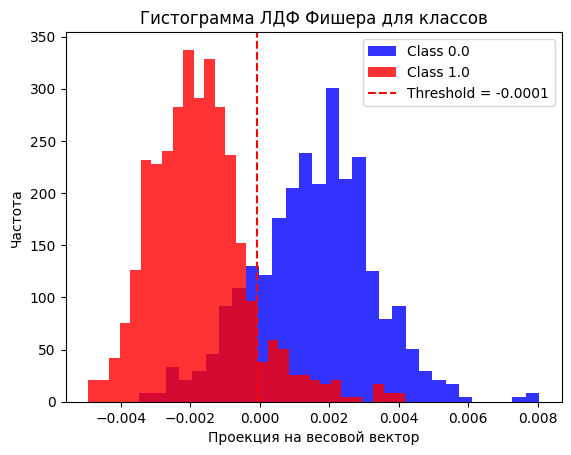


Оценка алгоритма Фишера на Обучающих данных (выборка a):


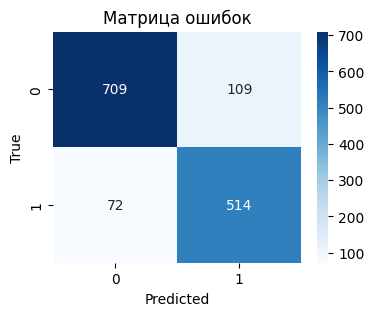

Точность(accuracy) = 0.871
Чувствительность(sensitivity) = 0.908
Специфичность(specificity) = 0.825




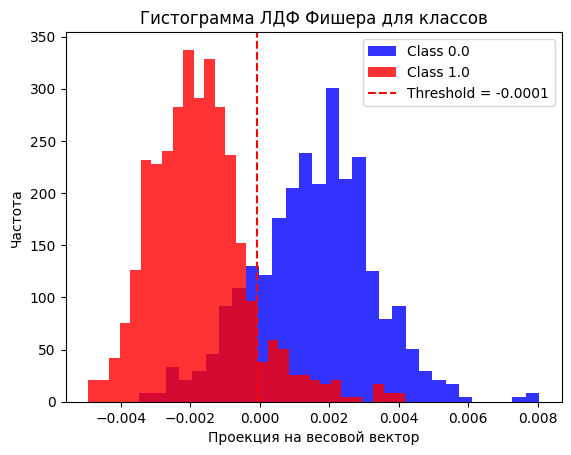


Оценка алгоритма Фишера на Тестовых данных (выборка a):


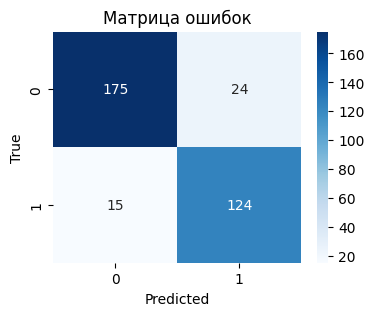

Точность(accuracy) = 0.885
Чувствительность(sensitivity) = 0.921
Специфичность(specificity) = 0.838




In [ ]:
# 6. Оценить результаты классификации на обучающем и тестовом наборе
# Оценка классификации Фишера для полной выборки данных (выборка а)
LDA_A_w, LDA_A_threshold = LDA('class', train_data_no_outliers)
predictions = LDA_predict(LDA_A_w, LDA_A_threshold, train_data_no_outliers.drop(columns='class'))
print()
print("Оценка алгоритма Фишера на Обучающих данных (выборка a):")
metrics(predictions, train_labels_no_outliers)

LDA_A_w, LDA_A_threshold = LDA('class', train_data_no_outliers)
predictions = LDA_predict(LDA_A_w, LDA_A_threshold, test_data_no_outliers.drop(columns='class'))
print()
print("Оценка алгоритма Фишера на Тестовых данных (выборка a):")
metrics(predictions, test_labels_no_outliers)

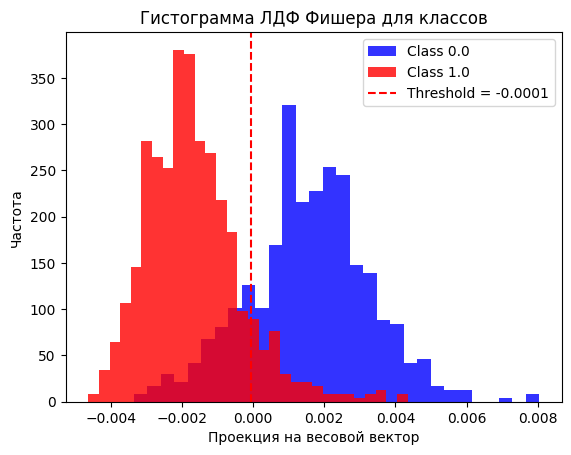


Оценка алгоритма Фишера на Обучающих данных (выборка b):


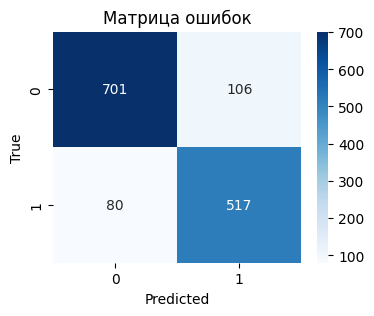

Точность(accuracy) = 0.868
Чувствительность(sensitivity) = 0.898
Специфичность(specificity) = 0.83




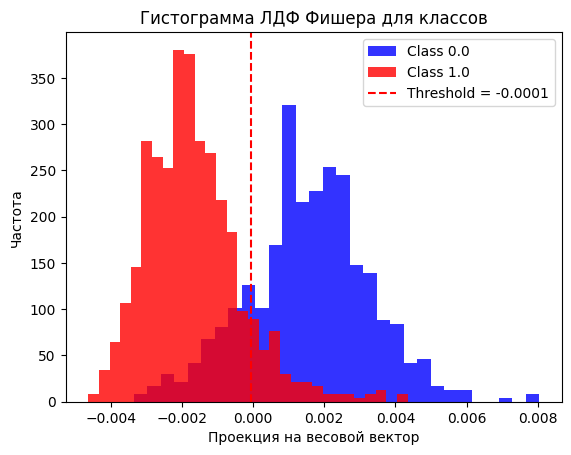


Оценка алгоритма Фишера на Тестовых данных (выборка b):


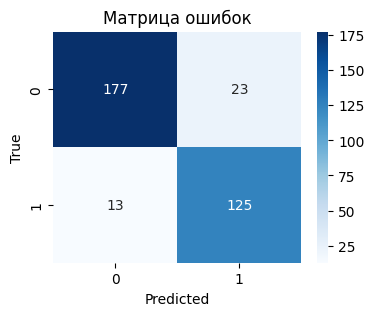

Точность(accuracy) = 0.893
Чувствительность(sensitivity) = 0.932
Специфичность(specificity) = 0.845




In [ ]:
# Оценка классификации Фишера для фильтрованной выборки данных (выборка b)
LDA_B_w, LDA_B_threshold = LDA('class', filtered_data)
predictions_filtered = LDA_predict(LDA_B_w, LDA_B_threshold, filtered_data.drop(columns='class'))
print()
print("Оценка алгоритма Фишера на Обучающих данных (выборка b):")
metrics(predictions_filtered, train_labels_no_outliers)

LDA_B_w, LDA_B_threshold = LDA('class', filtered_data)
predictions_filtered = LDA_predict(LDA_B_w, LDA_B_threshold, test_filtered_data.drop(columns='class'))
print()
print("Оценка алгоритма Фишера на Тестовых данных (выборка b):")
metrics(predictions_filtered, test_labels_no_outliers)

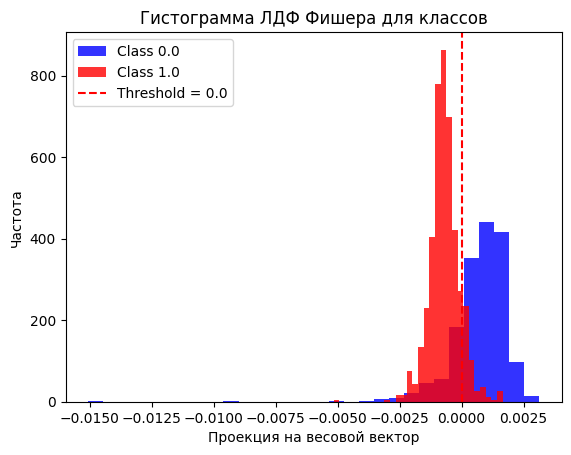


Оценка алгоритма Фишера на обучающих данных (выборка c)


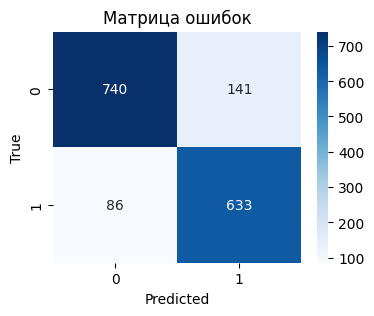

Точность(accuracy) = 0.858
Чувствительность(sensitivity) = 0.896
Специфичность(specificity) = 0.818




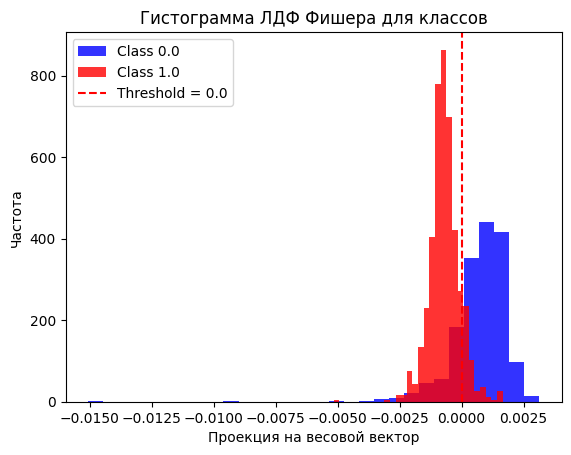


Оценка алгоритма Фишера на обучающих данных (выборка c)


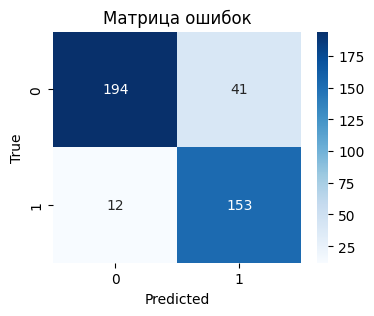

Точность(accuracy) = 0.868
Чувствительность(sensitivity) = 0.942
Специфичность(specificity) = 0.789




In [ ]:
# Оценка классификации Фишера для PCA выборки данных (выборка с)
pca_train_df = pd.DataFrame(pca_train_data, columns=['PCA1', 'PCA2', 'PCA3'])
pca_train_df['class'] = train_labels.values
pca_test_df = pd.DataFrame(pca_test_data, columns=['PCA1', 'PCA2', 'PCA3'])
pca_test_labels = test_labels

LDA_pca_w, LDA_pca_threshold = LDA('class', pca_train_df)
train_predictions = LDA_predict(LDA_pca_w, LDA_pca_threshold, pca_train_df.drop(columns='class'))
print()
print("Оценка алгоритма Фишера на обучающих данных (выборка c)")
metrics(train_predictions, train_labels)

LDA_pca_w, LDA_pca_threshold = LDA('class', pca_train_df)
pca_predictions = LDA_predict(LDA_pca_w, LDA_pca_threshold, pca_test_df)
print()
print("Оценка алгоритма Фишера на обучающих данных (выборка c)")
metrics(pca_predictions, pca_test_labels)

In [ ]:
# 5. б) Логистическая регрессия (с градиентным спуском)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression(X, y, X_val, y_val, lr=0.01, epochs=1000):
    # Инициализация
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    sigmoid_outputs = [] # Список для хранения предсказаний сигмоиды

    for epoch in range(epochs):
        # Прямой проход
        linear_model = np.dot(X, weights) + bias
        predictions = sigmoid(linear_model)

        # Выходы сигмоиды
        sigmoid_outputs.append(predictions)

        # Функция потерь для обучающей выборки
        train_loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        train_losses.append(train_loss)

        # Обратный проход (Вычисление градиентов)
        dw = (1 / m) * np.dot(X.T, (predictions - y))
        db = (1 / m) * np.sum(predictions - y)

        # Обновление весов
        weights -= lr * dw
        bias -= lr * db

        # Точность для обучающей выборки
        train_acc = np.mean((predictions >= 0.5).astype(int) == y)
        train_accuracies.append(train_acc)

        # Функция потерь для тестовой выборки
        val_linear_model = np.dot(X_val, weights) + bias
        val_predictions = sigmoid(val_linear_model)
        val_loss = -np.mean(y_val * np.log(val_predictions) + (1 - y_val) * np.log(1 - val_predictions))
        val_losses.append(val_loss)

        # Точность для тестовой выборки
        val_acc = np.mean((val_predictions >= 0.5).astype(int) == y_val)
        val_accuracies.append(val_acc)

    return weights, bias, train_losses, train_accuracies, val_losses, val_accuracies, sigmoid_outputs

def predict_logistic(X, weights, bias, threshold=0.5):
    linear_model = np.dot(X, weights) + bias
    probabilities = sigmoid(linear_model)
    return (probabilities >= threshold).astype(int)

In [ ]:
def metrics(predictions, true_y):
    TP = np.sum((predictions == 1) & (true_y == 1))  # Истинно положительные предсказания
    TN = np.sum((predictions == 0) & (true_y == 0))  # Истинно отрицательные предсказания
    FP = np.sum((predictions == 1) & (true_y == 0))  # Ложно положительные предсказания
    FN = np.sum((predictions == 0) & (true_y == 1))  # Ложно отрицательные предсказания
    Confusion_matrix = np.array([[TP, FP], [FN, TN]])

    plt.figure(figsize=(4, 3))
    sns.heatmap(Confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Матрица ошибок')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    accuracy = (TP + TN) / (TP + TN + FP + FN) # Показывает долю правильных предсказаний среди всех.
    print("Точность(accuracy) =", accuracy.round(3))
    sensitivity = TP / (TP + FN) # Показывает, какую долю реальных положительных случаев модель правильно распознала.
    print("Чувствительность(sensitivity) =", sensitivity.round(3)) # Высокая чувствительность нужна, когда важно не пропустить положительные случаи.
    specificity = TN / (TN + FP) # Показывает, какую долю реальных отрицательных случаев модель правильно распознала.
    print("Специфичность(specificity) =", specificity.round(3)) # Высокая специфичность нужна, чтобы минимизировать ложные срабатывания.
    print()
    print()

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 4))

    # График функции потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Обучение', color='blue')
    plt.plot(epochs, val_losses, label='Тест', color='red')
    plt.title('График функции потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Функция потерь')
    plt.legend()

    # График точности обучения
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Обучение', color='blue')
    plt.plot(epochs, val_accuracies, label='Тест', color='red')
    plt.title('График точности')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_sigmoid_histogram(sigmoid_outputs):
    threshold = 0.5
    plt.figure(figsize=(5.5, 3))
    plt.hist(sigmoid_outputs, bins=30, color='#4682B4', edgecolor='black')
    plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
    plt.title('Гистограмма выхода сигмоиды')
    plt.xlabel('Значение выхода сигмоиды')
    plt.ylabel('Частота')
    plt.show()

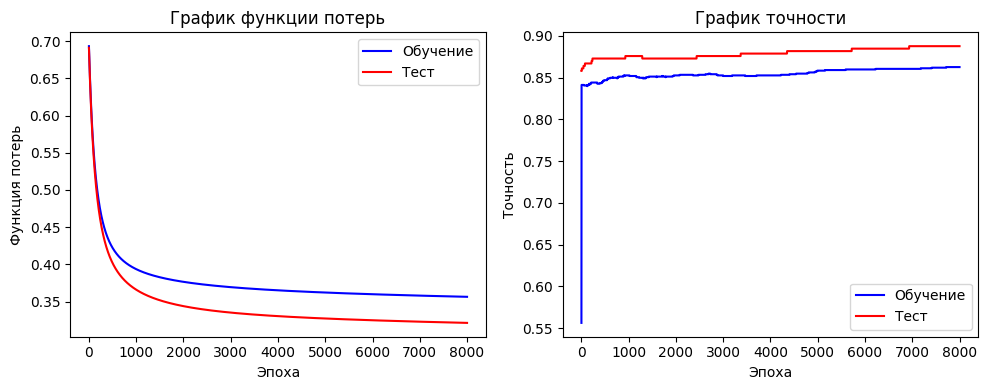

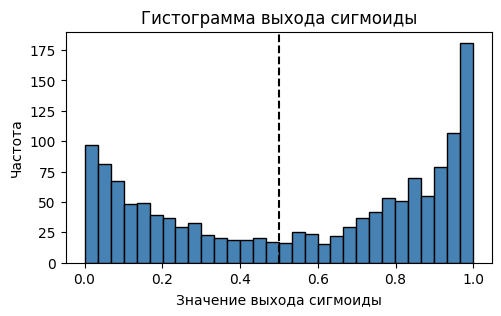


Оценка алгоритма логистической регрессии на Обучающих данных (выборка а):


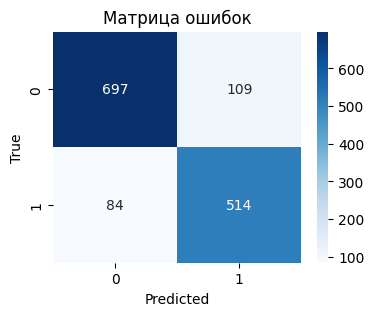

Точность(accuracy) = 0.863
Чувствительность(sensitivity) = 0.892
Специфичность(specificity) = 0.825


Оценка алгоритма логистической регрессии на Тестовых данных (выборка а):


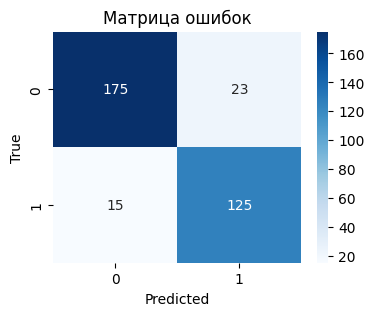

Точность(accuracy) = 0.888
Чувствительность(sensitivity) = 0.921
Специфичность(specificity) = 0.845




In [ ]:
# 6. Оценить результаты классификации на обучающем и тестовом наборе
# Оценка классификации Логистической регрессии для полной выборки данных (выборка а)
X_train = full_feature_data.drop(columns='class').values
y_train = full_feature_data['class'].values
X_test = test_full_feature_data.drop(columns='class').values
y_test = test_full_feature_data['class'].values

weights, bias, train_losses, train_accuracies, val_losses, val_accuracies, sigmoid_outputs = logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.01, epochs=8000
)

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
print()
plot_sigmoid_histogram(sigmoid_outputs[-1])
print()

print("Оценка алгоритма логистической регрессии на Обучающих данных (выборка а):")
train_predictions = predict_logistic(X_train, weights, bias)
metrics(train_predictions, y_train)

print("Оценка алгоритма логистической регрессии на Тестовых данных (выборка а):")
test_predictions = predict_logistic(X_test, weights, bias)
metrics(test_predictions, y_test)

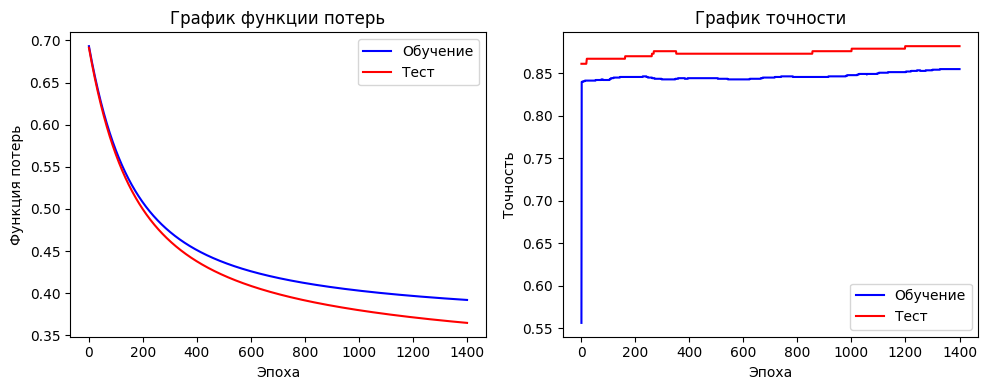

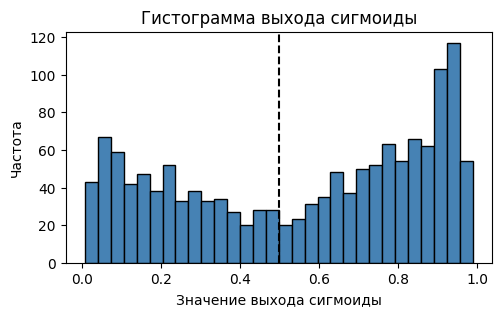


Оценка алгоритма логистической регрессии на Обучающих данных (выборка b):


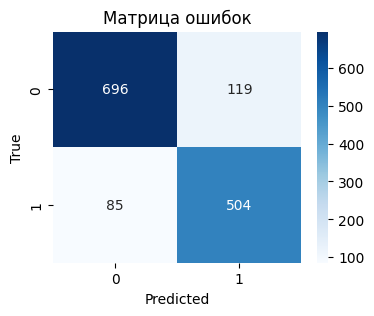

Точность(accuracy) = 0.855
Чувствительность(sensitivity) = 0.891
Специфичность(specificity) = 0.809


Оценка алгоритма логистической регрессии на Тестовых данных (выборка b):


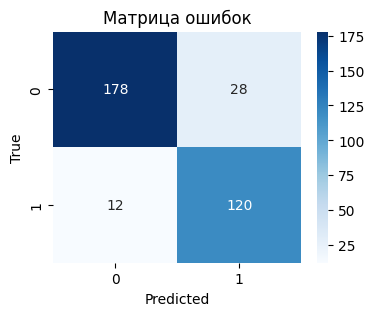

Точность(accuracy) = 0.882
Чувствительность(sensitivity) = 0.937
Специфичность(specificity) = 0.811




In [ ]:
# Оценка классификации Логистической регрессии для фильтрованной выборки данных (выборка b)
X_train_b = filtered_data.drop(columns='class').values
y_train_b = filtered_data['class'].values
X_test_b = test_filtered_data.drop(columns='class').values
y_test_b = test_filtered_data['class'].values

weights_b, bias_b, train_losses_b, train_accuracies_b, val_losses_b, val_accuracies_b, sigmoid_outputs_b = logistic_regression(
    X_train_b, y_train_b, X_test_b, y_test_b, lr=0.01, epochs=1400
)

plot_metrics(train_losses_b, train_accuracies_b, val_losses_b, val_accuracies_b)
print()
plot_sigmoid_histogram(sigmoid_outputs_b[-1])
print()

print("Оценка алгоритма логистической регрессии на Обучающих данных (выборка b):")
train_predictions_b = predict_logistic(X_train_b, weights_b, bias_b)
metrics(train_predictions_b, y_train_b)

print("Оценка алгоритма логистической регрессии на Тестовых данных (выборка b):")
test_predictions_b = predict_logistic(X_test_b, weights_b, bias_b)
metrics(test_predictions_b, y_test_b)

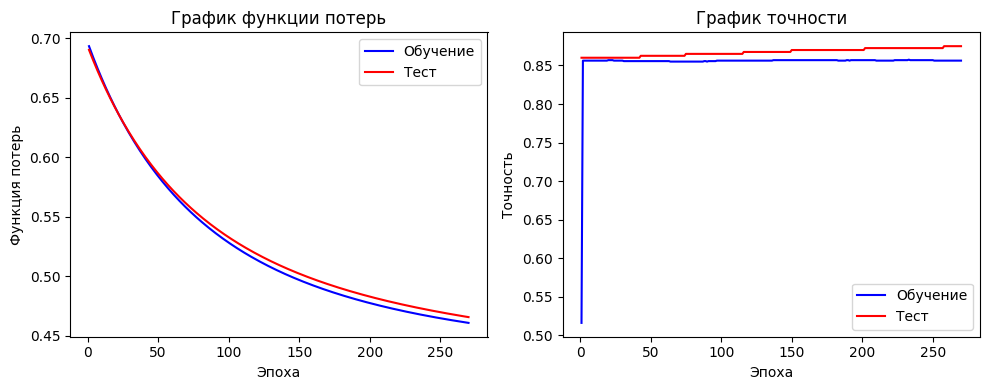

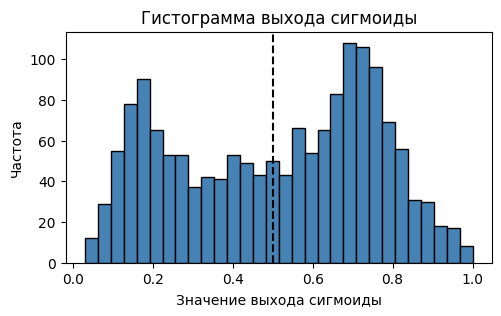


Оценка алгоритма логистической регрессии на Обучающих данных (выборка c):


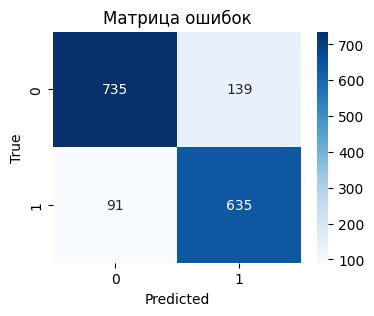

Точность(accuracy) = 0.856
Чувствительность(sensitivity) = 0.89
Специфичность(specificity) = 0.82


Оценка алгоритма логистической регрессии на Тестовых данных (выборка c):


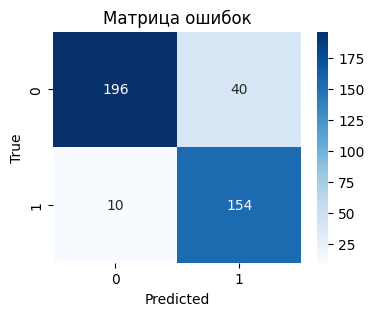

Точность(accuracy) = 0.875
Чувствительность(sensitivity) = 0.951
Специфичность(specificity) = 0.794




In [ ]:
# Оценка классификации Логистической регрессии для PCA выборки данных (выборка с)
weights_c, bias_c, train_losses_c, train_accuracies_c, val_losses_c, val_accuracies_c, sigmoid_outputs_c = logistic_regression(
    pca_train_data, train_labels.values, pca_test_data, test_labels.values, lr=0.01, epochs=270
)

plot_metrics(train_losses_c, train_accuracies_c, val_losses_c, val_accuracies_c)
print()
plot_sigmoid_histogram(sigmoid_outputs_c[-1])
print()

print("Оценка алгоритма логистической регрессии на Обучающих данных (выборка c):")
train_predictions_c = predict_logistic(pca_train_data, weights_c, bias_c)
metrics(train_predictions_c, train_labels.values)

print("Оценка алгоритма логистической регрессии на Тестовых данных (выборка c):")
test_predictions_c = predict_logistic(pca_test_data, weights_c, bias_c)
metrics(test_predictions_c, test_labels.values)

In [ ]:
# 5*. Алгоритм Forward Selection
def forward_selection(X, y, test_X, test_y, lr=0.01, epochs=1000):
    selected_features = [] # Список выбранных признаков
    remaining_features = list(range(X.shape[1])) # Список признаков
    best_score = 0
    history = [] # История выбранных признаков и изменений точности

    while remaining_features:
        scores = [] # Список для хранения точности каждого признака
        for feature in remaining_features:
            current_features = selected_features + [feature] # Добавляем текущий признак в набор выбранных признаков

            # Обучение на текущем наборе признаков
            weights, bias, train_losses, train_accuracies, val_losses, val_accuracies, sigmoid_outputs = logistic_regression(
                X[:, current_features], y, test_X[:, current_features], test_y, lr=lr, epochs=epochs
            )

            # Точность для тестовой выборки
            current_accuracy = val_accuracies[-1]
            scores.append((current_accuracy, feature))

        # Сортировка результатов по точности
        scores.sort(reverse=True, key=lambda x: x[0])
        best_accuracy, best_feature = scores[0] # Первый в отсортированном списке (с наибольшей точностью)

        # Проверка улучшения точности. Цикл(while) останавливается если нет улучшения точности.
        if best_accuracy > best_score:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_score = best_accuracy
            history.append((selected_features.copy(), best_score))
            print(f"Добавлен признак: {best_feature}, Точность: {best_score:.6f}")
        else:
            print("Точность не улучшается.")
            break
    print()
    print("Итоговые выбранные признаки (с помощью Forward Selection):", selected_features)
    return selected_features, history

In [ ]:
# Оценка Forward Selection для полной выборки данных
X_train = full_feature_data.drop(columns='class').values
y_train = full_feature_data['class'].values
X_test = test_full_feature_data.drop(columns='class').values
y_test = test_full_feature_data['class'].values

selected_features, history = forward_selection(X_train, y_train, X_test, y_test, lr=0.01, epochs=1000)

Добавлен признак: 10, Точность: 0.778107
Добавлен признак: 3, Точность: 0.813609
Добавлен признак: 5, Точность: 0.816568
Точность не улучшается.

Итоговые выбранные признаки (с помощью Forward Selection): [10, 3, 5]


# Дополнение. График выхода сигмоиды с разделением классов

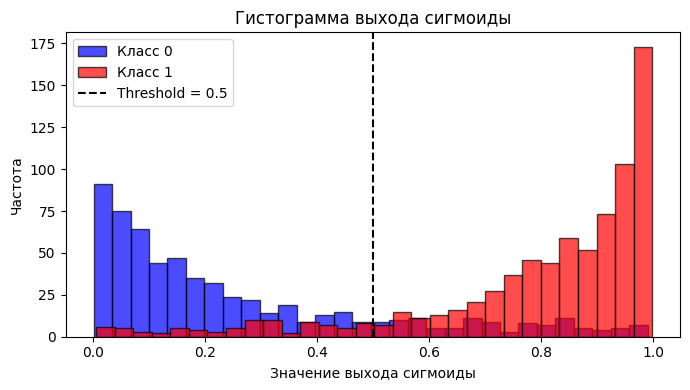

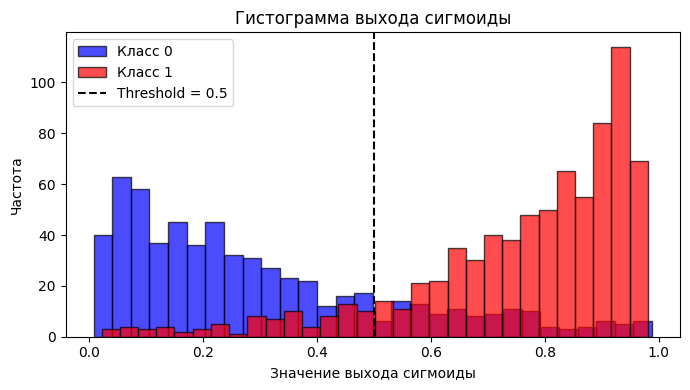

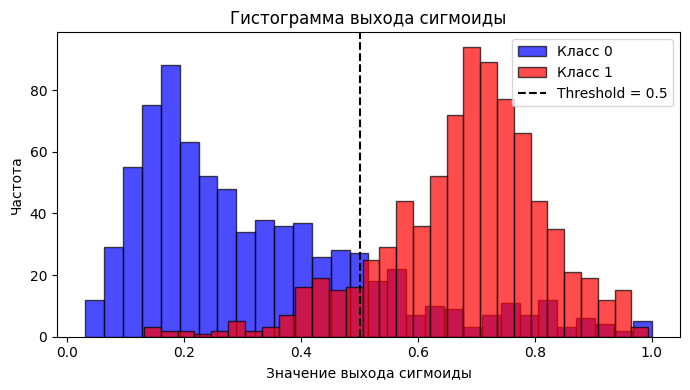

In [ ]:
def plot_sigmoid_histogram(sigmoid_outputs, y):
    threshold = 0.5

    # Преобразуем y в numpy-массив
    y = np.array(y)
    sigmoid_outputs = np.array(sigmoid_outputs)

    # Разделяем сигмоидные выходы по классам
    class_0_outputs = sigmoid_outputs[y == 0]
    class_1_outputs = sigmoid_outputs[y == 1]

    plt.figure(figsize=(7, 4))

    # Рисуем гистограммы для каждого класса
    plt.hist(class_0_outputs, bins=30, color='blue', alpha=0.7, edgecolor='black', label='Класс 0')
    plt.hist(class_1_outputs, bins=30, color='red', alpha=0.7, edgecolor='black', label='Класс 1')

    # Добавляем пороговое значение
    plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')

    plt.title('Гистограмма выхода сигмоиды')
    plt.xlabel('Значение выхода сигмоиды')
    plt.ylabel('Частота')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Вызов функции с использованием последнего выхода сигмоиды и истинных меток классов
y_train_np = np.array(y_train)
y_trainb_np = np.array(y_train_b)
y_trainc_np = np.array(train_labels.values)
plot_sigmoid_histogram(sigmoid_outputs[-1], y_train_np)
plot_sigmoid_histogram(sigmoid_outputs_b[-1], y_trainb_np)
plot_sigmoid_histogram(sigmoid_outputs_c[-1], y_trainc_np )